In [21]:
%matplotlib widget

import sys

import datacube
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

sys.path.insert(1, "../Tools/")
import datacube
import matplotlib.animation as animation
import matplotlib.patheffects as PathEffects
from dea_tools.plotting import display_map, rgb, xr_animation
from IPython.display import Image
from matplotlib import colors as mcolours
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MaxNLocator
from dea_tools.bandindices import calculate_indices

In [22]:
dc = datacube.Datacube()

In [23]:
def rescale_level3(data):
    """rescale distribution of level three classes to be 0-6 for neat plotting in pixel drill plot
    Input : xarray DataSet or DataArray containing level 3 land cover data
    """
    scale_and_lables = {0: 0, 111: 1, 112: 2, 124: 3, 215: 4, 216: 5, 220: 6}

    for key, value in scale_and_lables.items():
        data = data.where(data != key, value)
    return data


def click_for_coords(event):
    """
    Define behaviour widget to enable extraction of x,y values for point manually selected with mouse click on interactive plot
    For use with Matplotlib Imshow.
    The x and y returned are the coordinate positions of the pixel in the x and y axis, rather than latitude/longitude values of the point.
    The coordinate positions of the pixel this is what you need latter to conduct a pixel drill.
    returns:
    ix, iy = position of selected pixel in the x and y coordinates of the array
    """
    global ix, iy
    ix, iy = event.xdata, event.ydata
    global coords
    coords.append((ix, iy))

    fig.canvas.mpl_disconnect(cid)
    return


def create_colour_map(colours):
    """create colour map and normalisation for plotting Land Cover layers
    input:
    dict, a dictionary defining the class numbers and corresponding RGB(A) colour values for the land cover layer to be plotted.
    returns:
    cmap, norm : Matplotlib colour map and colour map normalisation
    """
    colour_arr = []
    cblabels = []
    for key, value in colours.items():
        colour_arr.append(np.array(value[:-2]) / 255)
        cblabels.append(value[-1])

    cmap = mcolours.ListedColormap(colour_arr)
    bounds = list(colours)
    bounds.append(255)
    norm = mcolours.BoundaryNorm(np.array(bounds) - 0.1, cmap.N)
    return cmap, norm

In [24]:
# select a center point for an AOI

# lake George
point_x, point_y = ( -34.3556, 140.6023)

buffer = 0.03

lat = (point_x - buffer, point_x + buffer)
lon = (point_y - buffer, point_y + buffer)

# display area on map
display_map(x=lon, y=lat)

In [25]:
query = {
    "y": lat,
    "x": lon,
    "time": ("2013", "2020"),
}

# Load DEA Land Cover data from the datacube
ls_data = dc.load(
    product="ga_ls8c_ard_3",
    output_crs="EPSG:3577",
    measurements=['red', 'nir'],
    resolution=(-25, 25),
    **query
)

# Load DEA Land Cover data from the datacube
landcover = dc.load(
    product="ga_ls_landcover_class_cyear_2",
    output_crs="EPSG:3577",
    measurements=['level3'],
    resolution=(-25, 25),
    **query
)

In [26]:
ls_data

<xarray.Dataset>
Dimensions:      (time: 172, y: 283, x: 238)
Coordinates:
  * time         (time) datetime64[ns] 2013-03-29T00:27:15.142280 ... 2020-12...
  * y            (y) float64 -3.773e+06 -3.773e+06 ... -3.78e+06 -3.78e+06
  * x            (x) float64 7.844e+05 7.844e+05 ... 7.903e+05 7.903e+05
    spatial_ref  int32 3577
Data variables:
    red          (time, y, x) int16 2559 2515 2494 2554 ... 2398 2378 2259 2249
    nir          (time, y, x) int16 3283 3243 3250 3323 ... 3459 3435 3237 3225
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [28]:
# Generate NDVI 
NDVI =  calculate_indices(ls_data, index='NDVI', collection ='ga_ls_3', drop=True)

Dropping bands ['red', 'nir']


In [29]:
NDVI

<xarray.Dataset>
Dimensions:      (time: 172, y: 283, x: 238)
Coordinates:
  * time         (time) datetime64[ns] 2013-03-29T00:27:15.142280 ... 2020-12...
  * y            (y) float64 -3.773e+06 -3.773e+06 ... -3.78e+06 -3.78e+06
  * x            (x) float64 7.844e+05 7.844e+05 ... 7.903e+05 7.903e+05
    spatial_ref  int32 3577
Data variables:
    NDVI         (time, y, x) float64 0.1239 0.1264 0.1316 ... 0.1779 0.1783
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [30]:
# define level three colour scheme

LEVEL3_COLOUR_SCHEME = {
    0: (255, 255, 255, 255, "No Data"),
    111: (172, 188, 45, 255, "Cultivated Terrestrial Vegetation"),
    112: (14, 121, 18, 255, "Natural Terrestrial Vegetation"),
    124: (30, 191, 121, 255, "Natural Aquatic Vegetation"),
    215: (218, 92, 105, 255, "Artificial Surface"),
    216: (243, 171, 105, 255, "Natural Bare Surface"),
    220: (77, 159, 220, 255, "Water"),
}

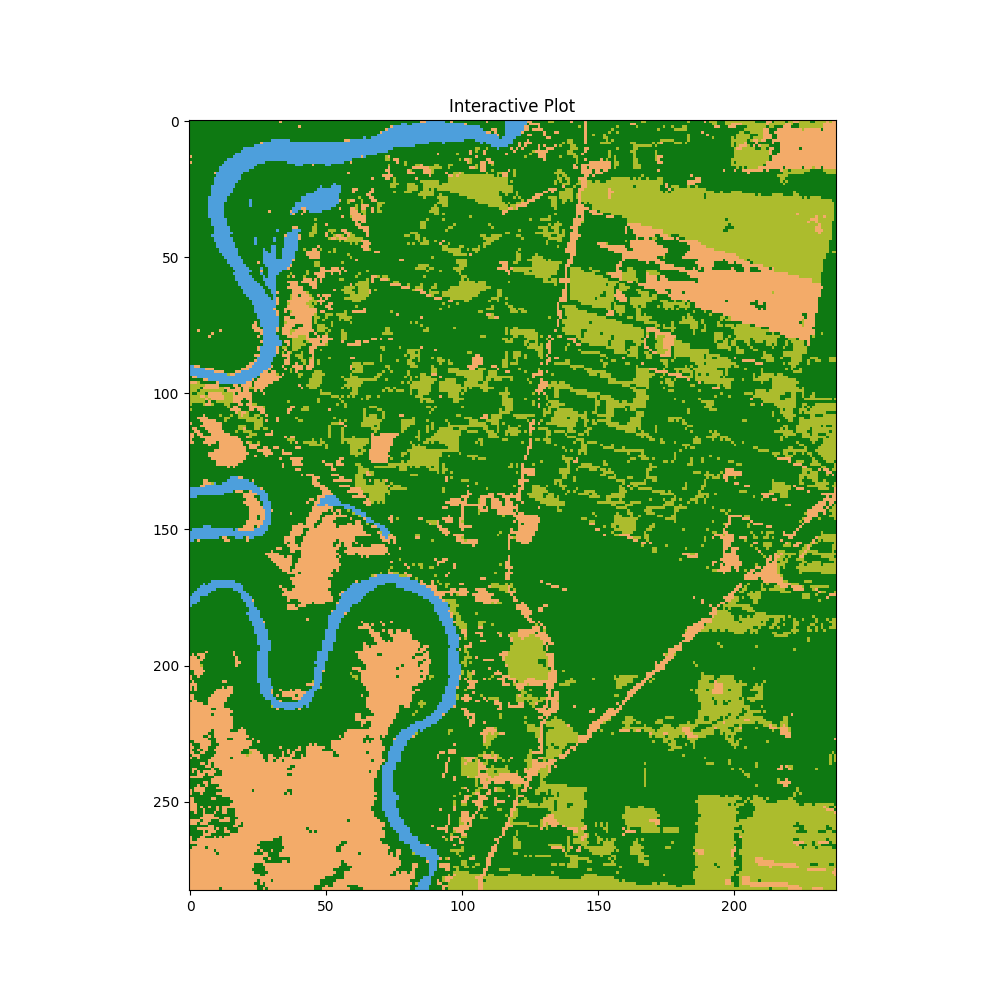

In [35]:
# build the colour map for level 3
layer_cmap, layer_norm = create_colour_map(LEVEL3_COLOUR_SCHEME)

# select year to plot
plot_year = "2020"

# create interactive plot
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.imshow(
    landcover.level3.sel(time=plot_year, method="nearest").squeeze(),
    cmap=layer_cmap,
    norm=layer_norm,
    interpolation="nearest",
)
cid = fig.canvas.mpl_connect("button_press_event", click_for_coords)
plt.title("Interactive Plot")

plt.show()

In [36]:
# Enter selected point
plt.clf()
ax = plt.imshow(
    landcover.level3.sel(time=plot_year, method="nearest").squeeze(),
    cmap=layer_cmap,
    norm=layer_norm,
    interpolation="nearest",
)
plt.scatter(x=ix, y=iy, c="r", s=80)

In [37]:
# find nearest whole number value for v,y
xcoord = int(ix)
ycoord = int(iy)

# conduct pixel drill on loaded dataset
NDVI_timeseries = NDVI.NDVI.isel(
    x=xcoord,
    y=ycoord,
)

# # conduct pixel drill on loaded dataset
# Landcover_timeseries = rescale_level3(landcover.level3.isel(
#     x=xcoord,
#     y=ycoord,
# ))

# # rescale the range of Level 3 classes for beautiful plotting


<function matplotlib.pyplot.show(close=None, block=None)>

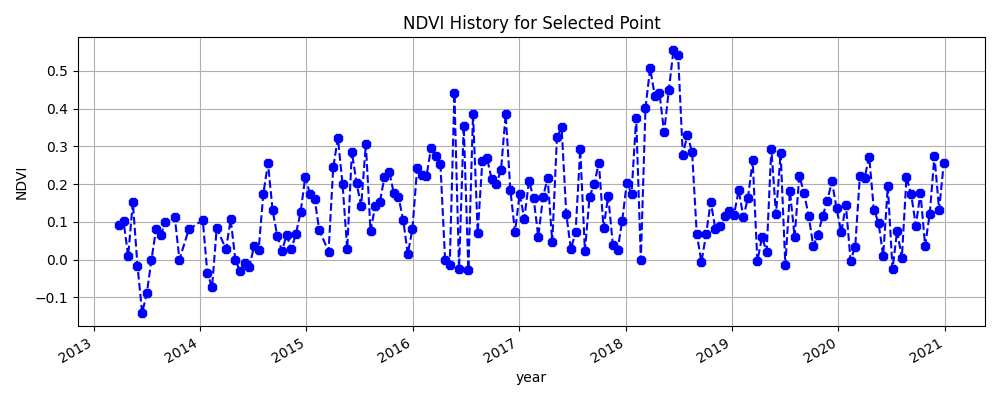

In [38]:
# define new figure and plot
fig, ax = plt.subplots(figsize=(10, 4))
# number_labels = (0, 1, 2, 3, 4, 5, 6)
# label_classes = (
#     "No Data",
#     "Cultivated Terrestrial\n Vegetation",
#     "Natural Terrestrial\n Vegetation",
#     "Natural Aquatic\n Vegetation",
#     "Artificial Surface",
#     "Natural Bare\n Surface",
#     "Water",
# )

# plt.yticks(number_labels, label_classes)  # make lables be class names
NDVI_timeseries.plot(linestyle="--", c="b", marker="8", mec="b", mfc="b")
plt.xlabel("year")
plt.title("NDVI History for Selected Point")
plt.grid()
plt.tight_layout()
plt.show

In [ ]:
# # define new figure and plot
# fig, ax = plt.subplots(figsize=(10, 4))
# number_labels = (0, 1, 2, 3, 4, 5, 6)
# label_classes = (
#     "No Data",
#     "Cultivated Terrestrial\n Vegetation",
#     "Natural Terrestrial\n Vegetation",
#     "Natural Aquatic\n Vegetation",
#     "Artificial Surface",
#     "Natural Bare\n Surface",
#     "Water",
# )

# plt.yticks(number_labels, label_classes)  # make lables be class names
# Landcover_timeseries.plot(linestyle="--", c="b", marker="8", mec="b", mfc="b")
# plt.xlabel("year")
# plt.title("Land Cover History for Selected Point")
# plt.grid()
# plt.tight_layout()
# plt.show